In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm.notebook import tqdm

## "All of Statistics: A Concise Course in Statistical Inference" 

### Chapter 13: Linear regression

**Problem 6** Get the passenger car mileage data from

https://www.stat.cmu.edu/~larry/all-of-statistics/=data/carmileage.dat (updated link)

(a) Fit a simple linear regression model to predict MPG (miles per gallon) from HP (horsepower). Summarize your analysis including a plot of the data with the fitted line.

(b) Repeat the analysis but use log(MPG) as the response. Compare the analysis.

   1. VOL: Cubic feet of cab space
   2. HP: Engine horspower
   3. MPG: Average miles per gallon
   4. SP: Top speed (mph)
   5. WT: Vehicle weight (100 lb) 

In [2]:
data = pd.read_csv('carmileage.csv', delim_whitespace=True)
data

,MAKE/MODEL,VOL,HP,MPG,SP,WT
0,GM/GeoMetroXF1,89,49,65.4,96,17.5
1,GM/GeoMetro,92,55,56.0,97,20.0
2,GM/GeoMetroLSI,92,55,55.9,97,20.0
3,SuzukiSwift,92,70,49.0,105,20.0
4,DaihatsuCharade,92,53,46.5,96,20.0
...,...,...,...,...,...,...
77,Mercedes500SL,50,322,18.1,165,45.0
78,Mercedes560SEL,115,238,17.2,140,45.0
79,JaguarXJSConvert,50,263,17.0,147,45.0
80,BMW750IL,119,295,16.7,157,45.0


In [3]:
X = data['HP']
Y = data['MPG']

slope = np.dot(X - X.mean(), Y - Y.mean()) / ((X - X.mean())**2).sum()
intercept = Y.mean() - slope * X.mean()

slope, intercept

(-0.13902325890251532, 50.06607807022756)

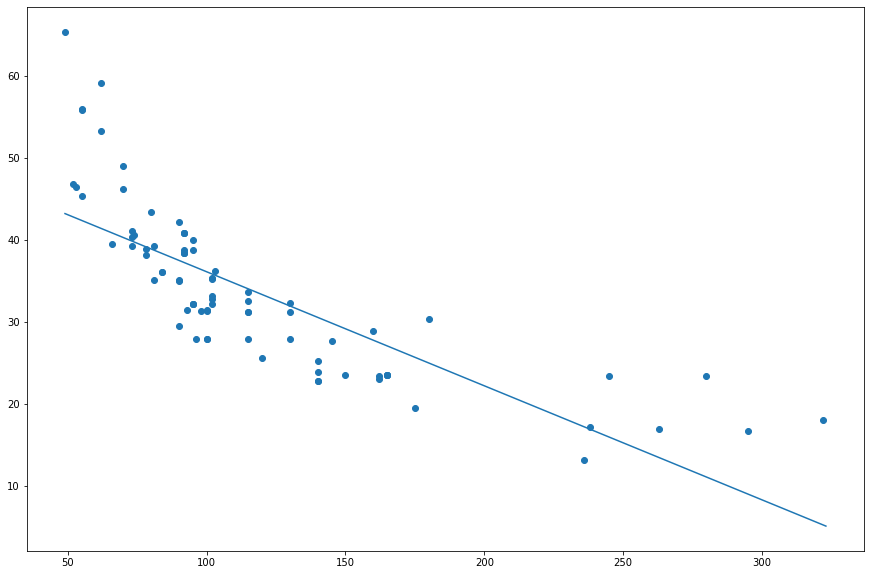

In [4]:
a = np.linspace(math.floor(X.min()), math.floor(X.max()) + 1)
plt.plot(a, slope * a + intercept)
plt.scatter(X, Y);

In [5]:
# now with statsmodels

results = sm.OLS(Y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     132.7
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           1.15e-18
Time:                        16:28:41   Log-Likelihood:                -264.61
No. Observations:                  82   AIC:                             533.2
Df Residuals:                      80   BIC:                             538.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0661      1.569     31.900      0.000      46.943      53.189
HP            -0.1390      0.012    -11.519      0.000      -0.163      -0.115
==============================================================================
Omnibus:                       22.759   Durbin-Watson:                   0.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.329
Skew:                           1.246   Prob(JB):                     1.57e-07
Kurtosis:                       4.722   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

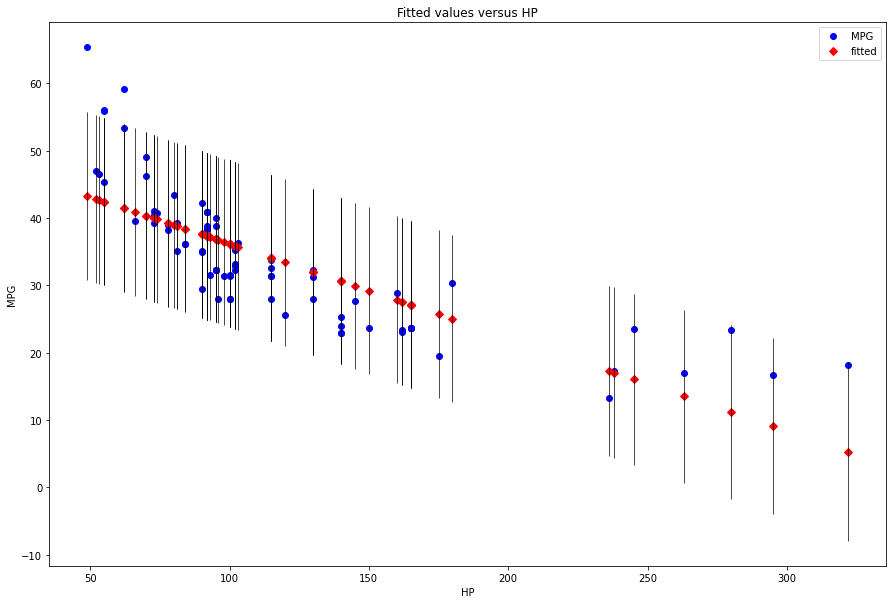

In [6]:
fig, ax = plt.subplots()

fig = sm.graphics.plot_fit(results, 1, ax=ax)

**Problem 7** Get the passenger car mileage data from

https://www.stat.cmu.edu/~larry/all-of-statistics/=data/carmileage.dat (updated link)

(a) Fit a multiple linear regression model to predict MPG (miles per gallon) from the other variables. Summarize your analysis.

(b) Use Mallow's $C_p$ to select a best sub-model. To search through all models try (i) forward stepwise, (ii) backward stepwise. Summarize your findings.

(c) Use the Zheng-Loh model selection method and compare to (b).

(d) Perform all possible regressions. Compare $C_p$ and BIC. Compare the results.

In [7]:
# part (a)

X = data[['VOL', 'HP', 'SP', 'WT']]
X.insert(0, 'ones', 1)
Y = data['MPG']

beta_hat = (np.linalg.inv(X.T @ X) @ X.T @ Y).to_numpy()
beta_hat
# np.square(Y - X @ beta_hat).sum() / (X.shape[0] - X.shape[1])

array([ 1.92437753e+02, -1.56450113e-02,  3.92212315e-01, -1.29481848e+00,
       -1.85980373e+00])

In [8]:
features = list(X.columns)
S = [features.pop(0)]

S, features

(['ones'], ['VOL', 'HP', 'SP', 'WT'])

In [9]:
# part (b)

beta_hat = (np.linalg.inv(X.T @ X) @ X.T @ Y).to_numpy()
# variance is estimated with the whole model
variance = np.square(Y - X @ beta_hat).sum() / (X.shape[0] - X.shape[1])

print(variance)

def C_p_compute(X, Y, S, variance):
    '''Compute Mallows' C_p statistic for feature indices S'''
    XS = X[S]
    beta_hat = (np.linalg.inv(XS.T @ XS) @ XS.T @ Y).to_numpy()
    rss = np.square(Y - XS @ beta_hat).sum()
    print(rss + 2 * (len(S) - 1) * variance, S)
    return rss + 2 * (len(S) - 1) * variance

def mallows_forward(X, Y, variance):
    '''Do a forward search to find a model with low C_p.
    Return the found feature indices S and the corresponding value of C_p'''
    features = list(X.columns)
    S = ['ones']
    f_min = 'ones'
    C_p_min = C_p_compute(X, Y, S, variance)
    while len(S) < len(features):
        updated = False
        for f in features:
            if f in S:
                continue
            C_p = C_p_compute(X, Y, S + [f], variance)
            if C_p < C_p_min:
                C_p_min = C_p
                f_min = f
                updated = True
        if updated:
            S.append(f_min)
        else:
            return S, C_p_min
    return S, C_p_min # S = features if we get to this point
        
mallows_forward(X, Y, variance)

13.342616587725459
8107.462560975609 ['ones']
7032.537818920606 ['ones', 'VOL']
3076.1203443449663 ['ones', 'HP']
4291.549376195874 ['ones', 'SP']
1492.6868612276942 ['ones', 'WT']
1515.4893978822654 ['ones', 'WT', 'VOL']
1483.992277361918 ['ones', 'WT', 'HP']
1436.391279881646 ['ones', 'WT', 'SP']
1417.109771318772 ['ones', 'WT', 'SP', 'VOL']
1113.7056379456403 ['ones', 'WT', 'SP', 'HP']
1134.1224099566643 ['ones', 'WT', 'SP', 'HP', 'VOL']


(['ones', 'WT', 'SP', 'HP'], 1113.7056379456403)

In [10]:
# part (b)

def mallows_backward(X, Y, variance):
    '''Do a backward search to find a model with low C_p.
    Return the found feature indices S and the corresponding value of C_p'''
    features = list(X.columns)
    S = features
    f_min = 'ones'
    C_p_min = C_p_compute(X, Y, S, variance)
    while len(S) > 1:
        updated = False
        for f in features:
            if f not in S:
                continue
            S_prov = [s for s in S if s != f]
            C_p = C_p_compute(X, Y, S_prov, variance)
            if C_p < C_p_min:
                C_p_min = C_p
                f_min = f
                updated = True
        if updated:
            S.remove(f_min)
        else:
            return S, C_p_min
    return S, C_p_min # S = features if we get to this point
        
mallows_backward(X, Y, variance)

# C_p_compute(X, Y, ['ones'], sigma)

1134.122409956664 ['ones', 'VOL', 'HP', 'SP', 'WT']
1999.7521036519995 ['VOL', 'HP', 'SP', 'WT']
1113.7056379456396 ['ones', 'HP', 'SP', 'WT']
1417.1097713187714 ['ones', 'VOL', 'SP', 'WT']
1480.7990944585135 ['ones', 'VOL', 'HP', 'WT']
2121.2012880492557 ['ones', 'VOL', 'HP', 'SP']
2005.1969891665199 ['HP', 'SP', 'WT']
1436.3912798816457 ['ones', 'SP', 'WT']
1483.992277361918 ['ones', 'HP', 'WT']
2409.8936088244304 ['ones', 'HP', 'SP']


(['ones', 'HP', 'SP', 'WT'], 1113.7056379456396)

In [11]:
# part (c)

def mallows_zheng_loh(X, Y):
    '''Fit full model and compute the Wald statistic of each beta_j.
    For each j, compute the RSS of the model with the j covariates with the largest Wald statistics.
    Find the model corresponding to the j minimizing: RSS(j) + j * residual_variance * np.log(Y.size).'''
    X = X.to_numpy()
    beta_hat = (np.linalg.inv(X.T @ X) @ X.T @ Y)
    residual_variance = np.square(Y - X @ beta_hat).sum()
    beta_variance_matrix = np.linalg.inv(X.T @ X) * residual_variance
    Wald_stats = np.abs(beta_hat / np.diagonal(beta_variance_matrix))
    Wald = list(enumerate(Wald_stats))
#     Wald = [(j, abs(beta_hat[j] / beta_variance_matrix[j, j])) for j in range(beta_hat.size)]
    Wald.sort(key=lambda t: - t[1])
    zl_stat = np.inf
    argmin = None
    for j in range(1, len(Wald)):
        indices = list(zip(*Wald))[0][:j]
        X_restr = X[:, indices]
        beta_restr = (np.linalg.inv(X_restr.T @ X_restr) @ X_restr.T @ Y)
        current_stat = np.square(Y - X_restr @ beta_restr).sum() + j * residual_variance * np.log(Y.size)
        if current_stat < zl_stat:
            zl_stat = current_stat
            argmin = j
        print(j, indices, current_stat)
    return list(zip(*Wald))[0][:argmin], zl_stat
        
indices, zl_stat = mallows_zheng_loh(X, Y)
cols = list(X.columns)

[cols[idx] for idx in indices], zl_stat

1 (2,) 46365.16145302727
2 (2, 4) 29206.742006314766
3 (2, 4, 1) 29472.74980224642
4 (2, 4, 1, 3) 20029.223324532744


(['HP', 'WT', 'VOL', 'SP'], 20029.223324532744)

In [12]:
# part (d): perform all possible regressions and compare C_p and BIC
# I'm going to skip the BIC part

from itertools import chain, combinations

X = data[['VOL', 'HP', 'SP', 'WT']]
X.insert(0, 'ones', 1)
Y = data['MPG']

def powerset(iterable): # Recipe from itertools
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))

def compute_C_p_for_all(X, Y):
    beta_hat = (np.linalg.inv(X.T @ X) @ X.T @ Y).to_numpy()
    # variance is estimated with the whole model
    variance = np.square(Y - X @ beta_hat).sum() / (X.shape[0] - X.shape[1])
    C_p_dic = {}
    for S in powerset(X.columns):
        XS = X[list(S)]
        beta_hat = (np.linalg.inv(XS.T @ XS) @ XS.T @ Y).to_numpy()
        rss = np.square(Y - XS @ beta_hat).sum()
        C_p_dic[S] = rss + 2 * (len(S) - 1) * variance, S
    return C_p_dic

pd.DataFrame(compute_C_p_for_all(X, Y), columns=compute_C_p_for_all(X, Y).keys())

,ones,VOL,HP,SP,WT,ones,ones,ones,ones,VOL,...,VOL,VOL,VOL,HP,ones,ones,ones,ones,VOL,ones
0,8107.462561,16800.653023,41837.779723,14104.349683,25895.131844,7032.537819,3076.120344,4291.549376,1492.686861,15964.302446,...,2115.715255,15943.975078,5694.357122,2005.196989,2121.201288,1480.799094,1417.109771,1113.705638,1999.752104,1134.12241
1,"(ones,)","(VOL,)","(HP,)","(SP,)","(WT,)","(ones, VOL)","(ones, HP)","(ones, SP)","(ones, WT)","(VOL, HP)",...,"(VOL, HP, SP)","(VOL, HP, WT)","(VOL, SP, WT)","(HP, SP, WT)","(ones, VOL, HP, SP)","(ones, VOL, HP, WT)","(ones, VOL, SP, WT)","(ones, HP, SP, WT)","(VOL, HP, SP, WT)","(ones, VOL, HP, SP, WT)"
